####Downloading and Loading the  Dataset from Kaggle

In [ ]:
!pip install kaggle -q

In [1]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kacpergregorowicz/house-plant-species --unzip -p house_plant_dataset

Dataset URL: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species
License(s): CC-BY-NC-SA-4.0


Found 2946 images belonging to 47 classes.
Found 10236 images belonging to 47 classes.
Found 1438 images belonging to 47 classes.

Training samples: 10236
Validation samples: 1438
Test samples: 2946


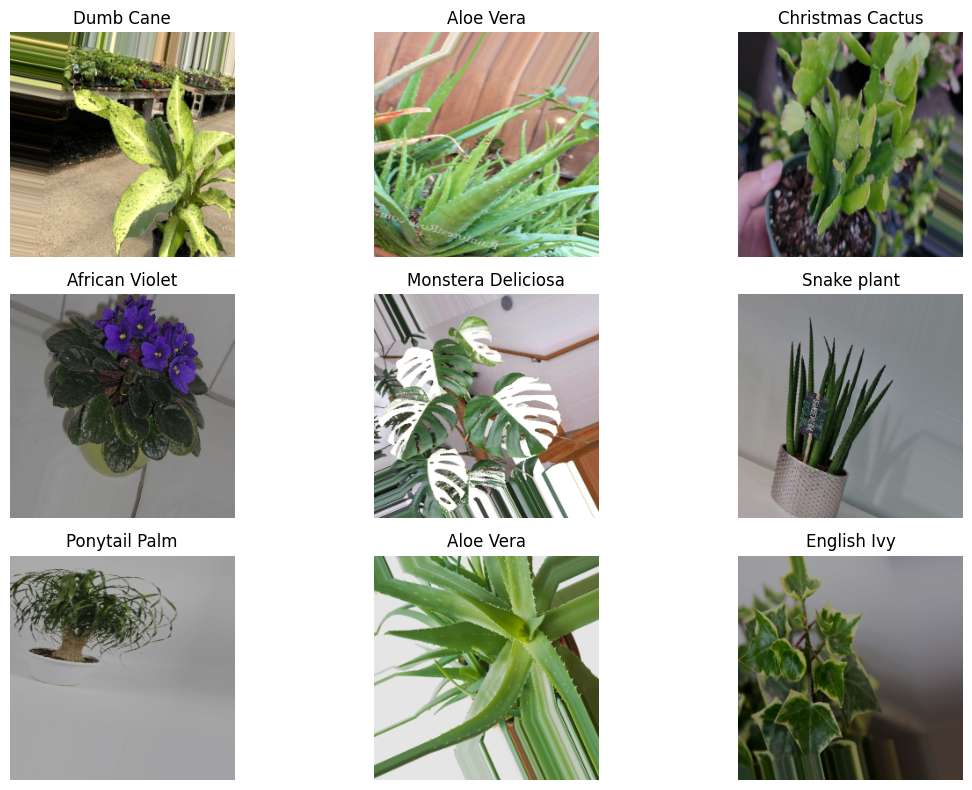

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np

# Split: 80% train+val, 20% test
dataset_path = '/content/house_plant_dataset/house_plant_species'
test_ratio = 0.2

temp_dir = '/content/temp_split'
os.makedirs(f"{temp_dir}/train_val", exist_ok=True)
os.makedirs(f"{temp_dir}/test", exist_ok=True)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Get all files in class
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        # Split files
        train_val_files, test_files = train_test_split(
            files, test_size=test_ratio, random_state=42, shuffle=True
        )
        os.makedirs(f"{temp_dir}/train_val/{class_name}", exist_ok=True)
        os.makedirs(f"{temp_dir}/test/{class_name}", exist_ok=True)
        for f in train_val_files:
            shutil.copy2(os.path.join(class_path, f), f"{temp_dir}/train_val/{class_name}/{f}")
        for f in test_files:
            shutil.copy2(os.path.join(class_path, f), f"{temp_dir}/test/{class_name}/{f}")

# 2. Now create generators
img_size = (256, 256)
batch_size = 32

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    f"{temp_dir}/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Train/val generator
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.125
)

train_generator = train_val_datagen.flow_from_directory(
    f"{temp_dir}/train_val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_val_datagen.flow_from_directory(
    f"{temp_dir}/train_val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

class_info = {
    'class_names': list(train_generator.class_indices.keys()),
    'class_counts': {cls: sum(train_generator.classes == idx)
                   for cls, idx in train_generator.class_indices.items()}
}

def clean_label(raw_name):
    """Extracts common name from folder format: 'Common Name (Scientific Name)'"""
    return raw_name.split('(')[0].strip()

plt.figure(figsize=(12, 8))
images, labels = next(train_generator)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    class_idx = tf.argmax(labels[i])
    plt.title(clean_label(class_info['class_names'][class_idx]))
    plt.axis('off')
plt.tight_layout()
plt.show()

Getting class names

In [ ]:
import os
base_path = '/content/house_plant_dataset/house_plant_species'

class_names = sorted(os.listdir(base_path))
print(f"Found {len(class_names)} classes:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

Found 47 classes:
0: African Violet (Saintpaulia ionantha)
1: Aloe Vera
2: Anthurium (Anthurium andraeanum)
3: Areca Palm (Dypsis lutescens)
4: Asparagus Fern (Asparagus setaceus)
5: Begonia (Begonia spp.)
6: Bird of Paradise (Strelitzia reginae)
7: Birds Nest Fern (Asplenium nidus)
8: Boston Fern (Nephrolepis exaltata)
9: Calathea
10: Cast Iron Plant (Aspidistra elatior)
11: Chinese Money Plant (Pilea peperomioides)
12: Chinese evergreen (Aglaonema)
13: Christmas Cactus (Schlumbergera bridgesii)
14: Chrysanthemum
15: Ctenanthe
16: Daffodils (Narcissus spp.)
17: Dracaena
18: Dumb Cane (Dieffenbachia spp.)
19: Elephant Ear (Alocasia spp.)
20: English Ivy (Hedera helix)
21: Hyacinth (Hyacinthus orientalis)
22: Iron Cross begonia (Begonia masoniana)
23: Jade plant (Crassula ovata)
24: Kalanchoe
25: Lilium (Hemerocallis)
26: Lily of the valley (Convallaria majalis)
27: Money Tree (Pachira aquatica)
28: Monstera Deliciosa (Monstera deliciosa)
29: Orchid
30: Parlor Palm (Chamaedorea elegans)

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Updated ImageDataGenerator configuration
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

# For the test/validation sets
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Training samples: 10236
Validation samples: 1438


Found 11715 images belonging to 47 classes.
Found 2905 images belonging to 47 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


184/184 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.1798 - loss: 3.3652 - top_k_categorical_accuracy: 0.3765 - val_accuracy: 0.7728 - val_loss: 0.8908 - val_top_k_categorical_accuracy: 0.9432 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.7617 - loss: 0.9349 - top_k_categorical_accuracy: 0.9359 - val_accuracy: 0.8702 - val_loss: 0.4312 - val_top_k_categorical_accuracy: 0.9862 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.8675 - loss: 0.4629 - top_k_categorical_accuracy: 0.9839 - val_accuracy: 0.9046 - val_loss: 0.3153 - val_top_k_categorical_accuracy: 0.9917 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.9093 - loss: 0.3057 - top_k_categorical_accuracy: 0.9930 - val_accuracy: 0.9177 - val_loss: 0.2662 - val_top_k_categorical_accuracy: 0.9924 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.

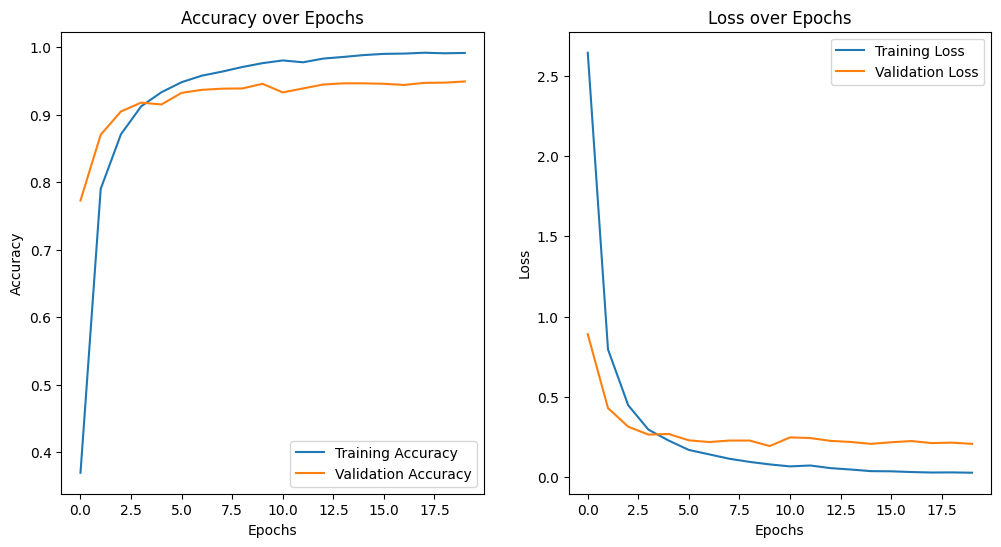

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Data cleaning function
def clean_image(x):
    if x.ndim == 2:  # Grayscale to RGB
        x = np.stack((x,)*3, axis=-1)
    elif x.shape[2] == 4:  # RGBA to RGB
        x = x[..., :3]
    return x

# 2. Data generators
def create_datagen():
    return ImageDataGenerator(
        preprocessing_function=lambda x: preprocess_input(clean_image(x)),
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.25,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.2
    )

train_datagen = create_datagen()
val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(clean_image(x)),
    validation_split=0.2
)

# 3. Data generators - train and validation
train_generator = train_datagen.flow_from_directory(
    '/content/house_plant_dataset/house_plant_species',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/house_plant_dataset/house_plant_species',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 4. Model setup
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True

# Freeze first layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(47, activation='softmax')  # 47 classes
])

# 5. Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

# 6. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# 7. Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler],
    # workers=1,
    # use_multiprocessing=False
)

# 8. Save the model
model.save('plant_identifier_model.keras')

# 9. Evaluate the model
eval_results = model.evaluate(val_generator)
print("Evaluation Results: Loss - {:.4f}, Accuracy - {:.4f}, Top-3 Accuracy - {:.4f}".format(*eval_results))

# 10. Plotting
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model = load_model('plant_identifier_model.keras')

# Set up the test data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(clean_image(x))
)

test_generator = test_datagen.flow_from_directory(
    '/content/temp_split/test',  # path to test data
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # No shuffle for evaluation
)

# 2. Evaluate the model on the test set
test_results = model.evaluate(test_generator)

# Print the results
print("Test Evaluation Results: Loss - {:.4f}, Accuracy - {:.4f}, Top-3 Accuracy - {:.4f}".format(*test_results))


Found 2946 images belonging to 47 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 3/47 ━━━━━━━━━━━━━━━━━━━━ 31s 714ms/step - accuracy: 0.9913 - loss: 0.0282 - top_k_categorical_accuracy: 1.0000

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9855 - loss: 0.0475 - top_k_categorical_accuracy: 0.9992
Test Evaluation Results: Loss - 0.0474, Accuracy - 0.9864, Top-3 Accuracy - 0.9990


In [ ]:
# 3. Get predictions
test_predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(test_predictions, axis=1)

# True classes
true_classes = test_generator.classes

# 4. Generate classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step

Classification Report:
                                            precision    recall  f1-score   support

     African Violet (Saintpaulia ionantha)       1.00      1.00      1.00        67
                                 Aloe Vera       1.00      1.00      1.00        51
          Anthurium (Anthurium andraeanum)       1.00      0.98      0.99        90
             Areca Palm (Dypsis lutescens)       0.95      1.00      0.97        38
       Asparagus Fern (Asparagus setaceus)       0.97      1.00      0.99        33
                    Begonia (Begonia spp.)       0.95      0.93      0.94        45
     Bird of Paradise (Strelitzia reginae)       1.00      1.00      1.00        35
         Birds Nest Fern (Asplenium nidus)       1.00      0.98      0.99        58
        Boston Fern (Nephrolepis exaltata)       0.98      1.00      0.99        58
                                  Calathea       0.95      0.92      0.94        66
      Cast I

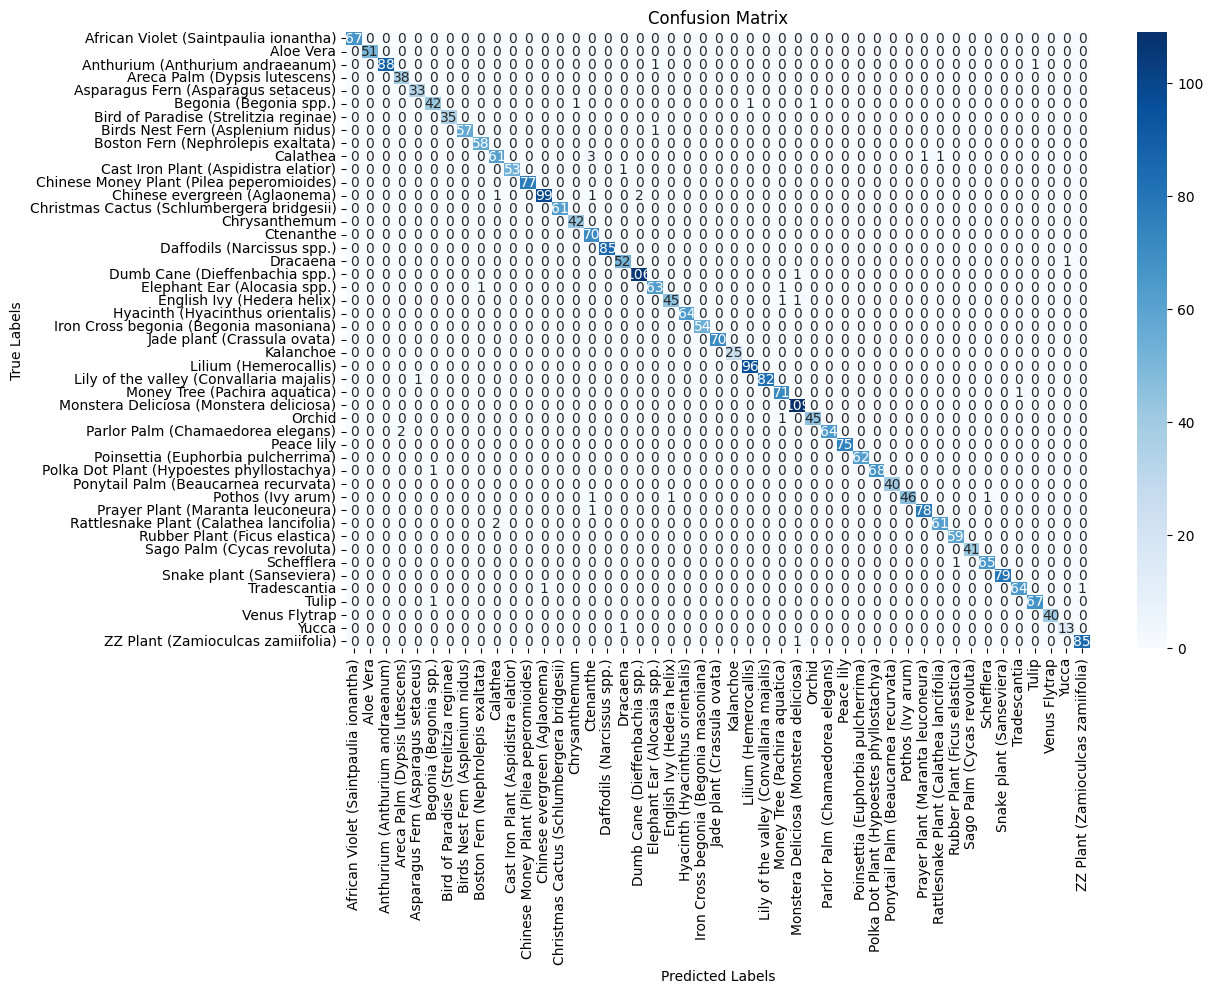

In [ ]:
# 5. Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 6. Calculate AUC (Area Under the Curve) for each class (one-vs-rest)
# This requires the test labels and predicted probabilities for the AUC score
y_true = np.zeros((len(true_classes), len(test_generator.class_indices)))  # One-hot encoding for true labels
y_true[np.arange(len(true_classes)), true_classes] = 1

# Get predicted probabilities
y_pred = test_predictions  # y_pred is the output probabilities from the model

# Compute AUC for each class
auc_scores = []
for i in range(len(test_generator.class_indices)):
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Print AUC scores for each class
print("\nAUC for each class:")
for i, class_name in enumerate(test_generator.class_indices.keys()):
    print(f"{class_name}: {auc_scores[i]:.4f}")


AUC for each class:
African Violet (Saintpaulia ionantha): 1.0000
Aloe Vera: 1.0000
Anthurium (Anthurium andraeanum): 1.0000
Areca Palm (Dypsis lutescens): 1.0000
Asparagus Fern (Asparagus setaceus): 1.0000
Begonia (Begonia spp.): 0.9998
Bird of Paradise (Strelitzia reginae): 1.0000
Birds Nest Fern (Asplenium nidus): 1.0000
Boston Fern (Nephrolepis exaltata): 1.0000
Calathea: 0.9998
Cast Iron Plant (Aspidistra elatior): 1.0000
Chinese Money Plant (Pilea peperomioides): 1.0000
Chinese evergreen (Aglaonema): 0.9997
Christmas Cactus (Schlumbergera bridgesii): 1.0000
Chrysanthemum: 1.0000
Ctenanthe: 0.9999
Daffodils (Narcissus spp.): 1.0000
Dracaena: 1.0000
Dumb Cane (Dieffenbachia spp.): 0.9999
Elephant Ear (Alocasia spp.): 0.9999
English Ivy (Hedera helix): 0.9999
Hyacinth (Hyacinthus orientalis): 1.0000
Iron Cross begonia (Begonia masoniana): 1.0000
Jade plant (Crassula ovata): 1.0000
Kalanchoe: 1.0000
Lilium (Hemerocallis): 1.0000
Lily of the valley (Convallaria majalis): 1.0000
Money

In [ ]:
# inference.py code // Sample code for the streamlit app

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# Load model
model = tf.keras.models.load_model('/content/plant_identifier_model.keras')  # Path to your Keras file

# Class names list (already auto-generated)
class_names = [
    "African Violet (Saintpaulia ionantha)", "Aloe Vera", "Anthurium (Anthurium andraeanum)",
    "Areca Palm (Dypsis lutescens)", "Asparagus Fern (Asparagus setaceus)", "Begonia (Begonia spp.)",
    "Bird of Paradise (Strelitzia reginae)", "Birds Nest Fern (Asplenium nidus)", "Boston Fern (Nephrolepis exaltata)",
    "Calathea", "Cast Iron Plant (Aspidistra elatior)", "Chinese Money Plant (Pilea peperomioides)",
    "Chinese evergreen (Aglaonema)", "Christmas Cactus (Schlumbergera bridgesii)", "Chrysanthemum",
    "Ctenanthe", "Daffodils (Narcissus spp.)", "Dracaena", "Dumb Cane (Dieffenbachia spp.)",
    "Elephant Ear (Alocasia spp.)", "English Ivy (Hedera helix)", "Hyacinth (Hyacinthus orientalis)",
    "Iron Cross begonia (Begonia masoniana)", "Jade plant (Crassula ovata)", "Kalanchoe",
    "Lilium (Hemerocallis)", "Lily of the valley (Convallaria majalis)", "Money Tree (Pachira aquatica)",
    "Monstera Deliciosa (Monstera deliciosa)", "Orchid", "Parlor Palm (Chamaedorea elegans)",
    "Peace lily", "Poinsettia (Euphorbia pulcherrima)", "Polka Dot Plant (Hypoestes phyllostachya)",
    "Ponytail Palm (Beaucarnea recurvata)", "Pothos (Ivy arum)", "Prayer Plant (Maranta leuconeura)",
    "Rattlesnake Plant (Calathea lancifolia)", "Rubber Plant (Ficus elastica)", "Sago Palm (Cycas revoluta)",
    "Schefflera", "Snake plant (Sanseviera)", "Tradescantia", "Tulip", "Venus Flytrap",
    "Yucca", "ZZ Plant (Zamioculcas zamiifolia)"
]

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((256, 256))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    # Get top 3 predictions
    top_3_idx = predictions[0].argsort()[-3:][::-1]
    top_3_classes = [class_names[i] for i in top_3_idx]
    top_3_confidences = predictions[0][top_3_idx]

    # Main prediction (highest confidence)
    top_pred_idx = np.argmax(predictions)
    confidence = np.max(predictions)
    predicted_class = class_names[top_pred_idx]

    return predicted_class, confidence, top_3_classes, top_3_confidences

# Example dry-run
if __name__ == "__main__":
    img_path = '/content/house_plant_dataset/house_plant_species/Cast Iron Plant (Aspidistra elatior)/105.png'  # Replace with actual path
    plant, confidence, top_3_classes, top_3_confidences = predict(img_path)

    # Print the top 3 predictions
    print(f"Predicted: {plant} ({confidence*100:.2f}% confidence)")
    print("Top 3 Predictions:")
    for i in range(3):
        print(f"{top_3_classes[i]}: {top_3_confidences[i]*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted: Bird of Paradise (Strelitzia reginae) (83.28% confidence)
Top 3 Predictions:
Bird of Paradise (Strelitzia reginae): 83.28%
Cast Iron Plant (Aspidistra elatior): 5.51%
Peace lily: 4.81%


Loaded 47 classes.


Saving Persea-americana.jpg.webp to Persea-americana.jpg.webp
Saving Asparagus-aethiopicus.jpg.webp to Asparagus-aethiopicus.jpg.webp
Saving Syngonium-podophyllum.jpg.webp to Syngonium-podophyllum.jpg.webp
Saving Anthurium-andraeanum-2.jpg.webp to Anthurium-andraeanum-2.jpg.webp
Saving Amaryllis.jpg.webp to Amaryllis.jpg.webp
Saving Aloe-vera.jpg.webp to Aloe-vera.jpg.webp
Saving Alocasia-Amazonica-‘Polly.jpg.webp to Alocasia-Amazonica-‘Polly.jpg.webp
Saving African-violet.jpg.webp to African-violet.jpg (1).webp
Saving Tillandsia-ionantha.jpg.webp to Tillandsia-ionantha.jpg (1).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


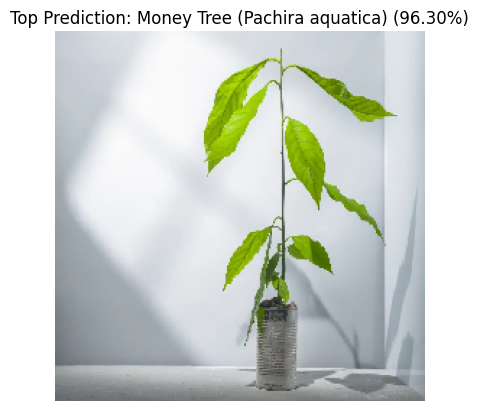


Top 3 Predictions:
Money Tree (Pachira aquatica): 96.30%
Schefflera: 1.41%
Pothos (Ivy arum): 1.02%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


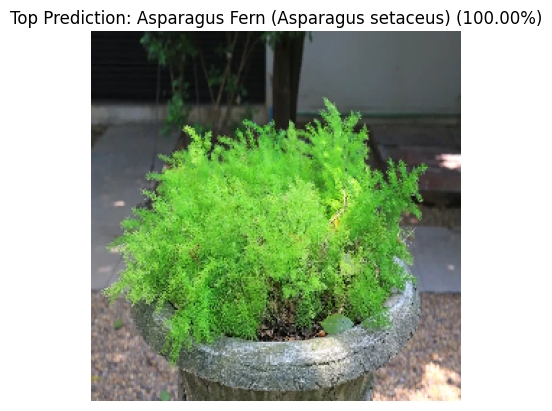


Top 3 Predictions:
Asparagus Fern (Asparagus setaceus): 100.00%
Begonia (Begonia spp.): 0.00%
Ponytail Palm (Beaucarnea recurvata): 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


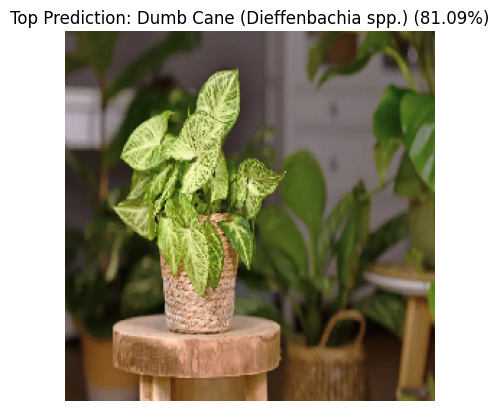


Top 3 Predictions:
Dumb Cane (Dieffenbachia spp.): 81.09%
Ctenanthe: 3.74%
Chinese evergreen (Aglaonema): 3.54%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


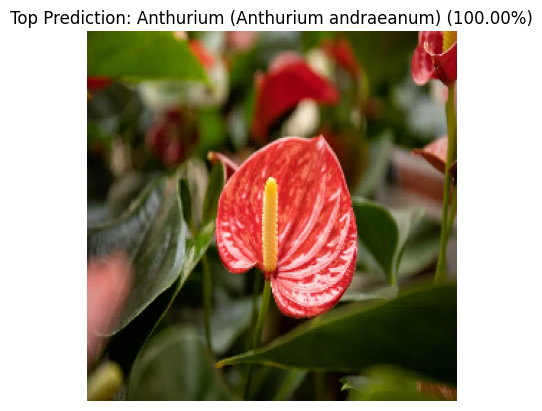


Top 3 Predictions:
Anthurium (Anthurium andraeanum): 100.00%
Peace lily: 0.00%
Chinese evergreen (Aglaonema): 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


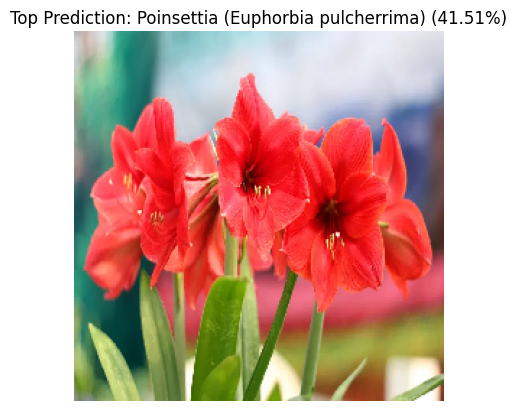


Top 3 Predictions:
Poinsettia (Euphorbia pulcherrima): 41.51%
Lilium (Hemerocallis): 33.53%
Daffodils (Narcissus spp.): 7.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


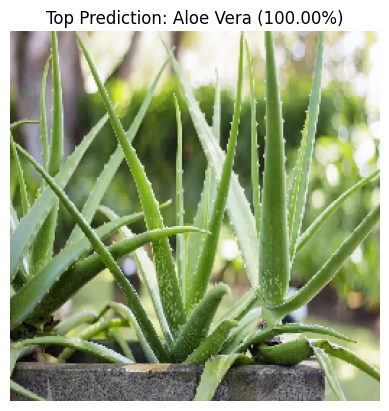


Top 3 Predictions:
Aloe Vera: 100.00%
Ponytail Palm (Beaucarnea recurvata): 0.00%
Kalanchoe: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


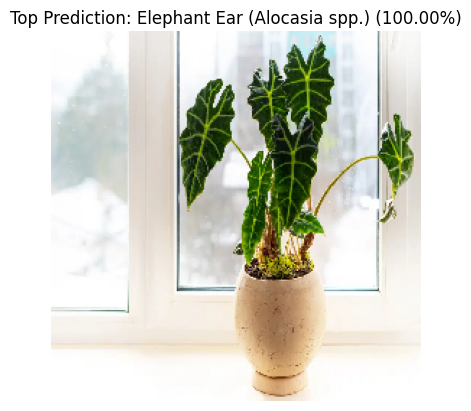


Top 3 Predictions:
Elephant Ear (Alocasia spp.): 100.00%
Anthurium (Anthurium andraeanum): 0.00%
Monstera Deliciosa (Monstera deliciosa): 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


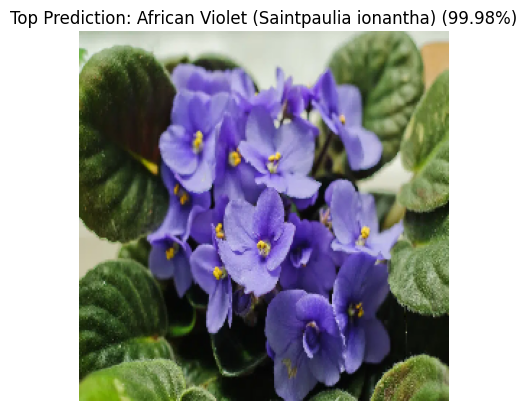


Top 3 Predictions:
African Violet (Saintpaulia ionantha): 99.98%
Kalanchoe: 0.00%
Tradescantia: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


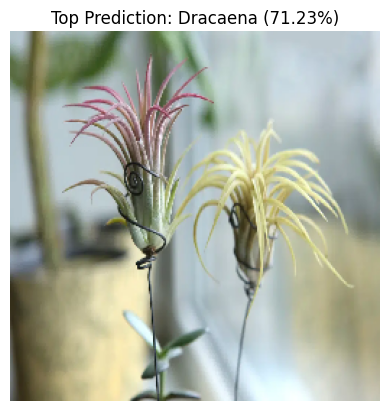


Top 3 Predictions:
Dracaena: 71.23%
Money Tree (Pachira aquatica): 13.80%
Ponytail Palm (Beaucarnea recurvata): 7.62%


In [ ]:
# -------------------------------------------
# LOAD THE SAVED MODEL
# -------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import os

#Model file
model = tf.keras.models.load_model('/content/plant_identifier_model.keras')

# Load class labels
class_labels = list(train_generator.class_indices.keys())  # same as training time
print(f"Loaded {len(class_labels)} classes.")

# -------------------------------------------
# FUNCTION TO PREDICT AN IMAGE
# -------------------------------------------
def load_and_prepare_image(img_path, target_size=(256, 256)):
    """Load and preprocess an image for prediction."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)

    # Handle grayscale or RGBA issues like during training
    if img_array.ndim == 2:  # grayscale
        img_array = np.stack((img_array,) * 3, axis=-1)
    elif img_array.shape[2] == 4:  # RGBA
        img_array = img_array[..., :3]

    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def predict_image(img_path):
    """Predict and plot image."""
    img_array = load_and_prepare_image(img_path)
    preds = model.predict(img_array)

    top3_idx = preds[0].argsort()[-3:][::-1]
    top3_probs = preds[0][top3_idx]
    top3_labels = [class_labels[i] for i in top3_idx]

    # Plot the image
    img = image.load_img(img_path, target_size=(256, 256))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Top Prediction: {top3_labels[0]} ({top3_probs[0]*100:.2f}%)")
    plt.show()

    print("\nTop 3 Predictions:")
    for label, prob in zip(top3_labels, top3_probs):
        print(f"{label}: {prob*100:.2f}%")

# -------------------------------------------
# USAGE EXAMPLE
# -------------------------------------------

from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    predict_image(filename)